In [1]:
# import libraries
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# Effects of imbalanced class
---

In [2]:
# Adjust weights to make the dataset imbalanced
random_state = 42 # choose between 42 or 69
X, y = make_classification(n_samples=1000, n_features=2,
                    n_informative=2, n_redundant=0, n_repeated=0, n_classes=2,
                    n_clusters_per_class=2, weights=[0.9, 0.1], # 90% of class 0, 10% of class 1
                    flip_y=0.01, class_sep=1.5, hypercube=True,
                    shift=0.0, scale=1.0, shuffle=True, random_state=random_state)

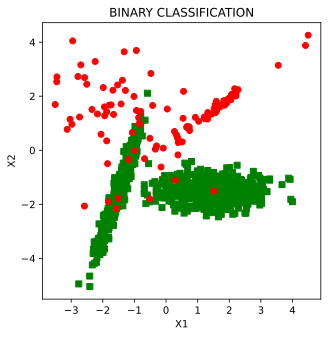

In [3]:
# convert to a pytorch tensor
data = torch.tensor(X).float()
labels = torch.tensor(y).float()
labels = labels.view(-1, 1)

# show the data
fig = plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels==0)[0],0],data[np.where(labels==0)[0],1],'gs')
plt.plot(data[np.where(labels==1)[0],0],data[np.where(labels==1)[0],1],'ro')
plt.title('BINARY CLASSIFICATION')
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

In [4]:
# a function that creates the ANN model

def model():
    # model architecture
    ann = nn.Sequential(
      nn.Linear(2,1),   # input layer
      nn.ReLU(),        # activation unit
      nn.Linear(1,1),   # output unit
        )

    # loss function
    lossfunc = nn.BCEWithLogitsLoss()

    # optimizer
    optim = torch.optim.SGD(ann.parameters(),lr=.01)

    # model output
    return ann,lossfunc,optim

In [5]:
# train the model

# global parameter
epochs = 200

def train(trainProp):

    # initialize losses
    losses = torch.zeros(epochs)
    train_accuracy = []
    test_accuracy  = []

    # loop over epochs
    for i in range(epochs):

        # separate train from test data
        # Note 1: unique split for each epoch!
        # Note 2: here we specify the training size, not the testing size!
        X_train,X_test, y_train,y_test = train_test_split(data,labels, train_size=trainProp, random_state=None, shuffle=True, stratify=None)


        # forward pass and loss
        pred_train = ann(X_train)
        loss = lossfunc(pred_train,y_train)

        # backprop
        optim.zero_grad()
        loss.backward()
        optim.step()

        pred_train_proba = torch.sigmoid(pred_train).detach()

        # convert probabilities to binary predictions (0 or 1) based on threshold of 0.5
        pred_train_labels = (pred_train_proba >= 0.5).float()

        # compute accuracy for train set
        train_accuracy.append(100 * torch.mean((pred_train_labels == y_train).float()).item())

        # get predicted probabilities for the test set and convert to binary predictions
        pred_test_proba = torch.sigmoid(ann(X_test)).detach()
        pred_test_labels = (pred_test_proba >= 0.5).float()

        # compute accuracy for test set
        test_accuracy.append(100 * torch.mean((pred_test_labels == y_test).float()).item())

    # function output
    return train_accuracy,test_accuracy


# Test the model by running it once

In [6]:
# create a model
ann,lossfunc,optim = model()

# train the model
# NOTE: the input is the training proportion, not the test proportion!
train_accuracy,test_accuracy = train(.8)


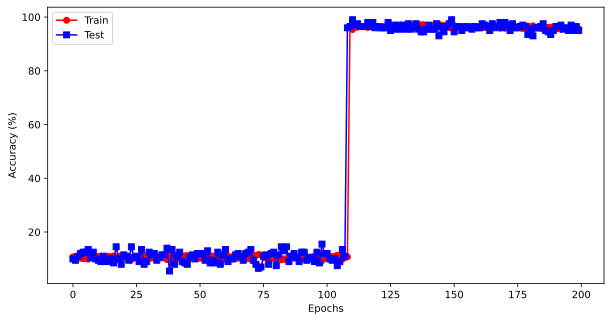

In [7]:
# plot the results
fig = plt.figure(figsize=(10,5))

plt.plot(train_accuracy,'ro-')
plt.plot(test_accuracy,'bs-')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend(['Train','Test'])
plt.show()

# What happened here?
---
Look at the graph of the data.


Important: Test accuracy should not exceed training accuracy, as the model is specifically optimized for the training data. Possible reasons for this behavior include:

1. The test dataset may differ from the training dataset. It’s crucial to perform a proper train/test split, ensuring both sets come from the same underlying distribution. It’s likely that the test data used was from a completely different, potentially easier, dataset.

2. Excessive regularization was applied. However, even with high regularization, the test and training data distributions would need to differ for this result to occur.

# Now for the experiment

In [8]:
trainSetSizes = np.linspace(.2,.95,10)

alltrain_accuracy = np.zeros((len(trainSetSizes),epochs))
alltest_accuracy = np.zeros((len(trainSetSizes),epochs))

for i in range(len(trainSetSizes)):

    # create a model
    ann,lossfunc,optim = model()

    # train the model
    train_accuracy,test_accuracy = train(trainSetSizes[i])

    # store the results
    alltrain_accuracy[i,:] = train_accuracy
    alltest_accuracy[i,:] = test_accuracy

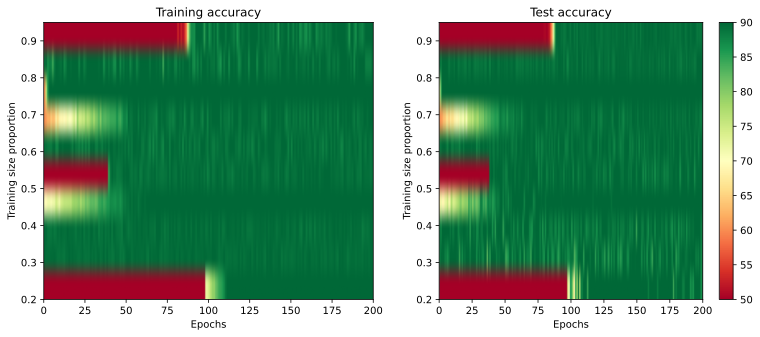

In [9]:
fig,ax = plt.subplots(1,2,figsize=(13,5))

# First plot with red-to-green spectrum
ax[0].imshow(alltrain_accuracy, aspect='auto', vmin=50, vmax=90,
             extent=[0, epochs, trainSetSizes[0], trainSetSizes[-1]], cmap='RdYlGn')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Training size proportion')
ax[0].set_title('Training accuracy')

# Second plot with red-to-green spectrum
p = ax[1].imshow(alltest_accuracy, aspect='auto', vmin=50, vmax=90,
                 extent=[0, epochs, trainSetSizes[0], trainSetSizes[-1]], cmap='RdYlGn')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training size proportion')
ax[1].set_title('Test accuracy')

# Adding a colorbar
fig.colorbar(p, ax=ax[1])

plt.show()

# Experiments

1. Redo the experiment but this time stratify the train-test split in terms of the y values. Compare the result to the original, provide an explaination.

2. Redo the experiment but this time try to set seed (any number) the experiment without stratification. Compare the result to the original, provide an explaination.

3. Redo the experiment but this time try to set seed (any number) the experiment with stratification. Compare the result to the original, provide an explaination.

4. Try to improve the model by adding more layers, and changing the value of the learning rate. Creat a bubblechart with the x-axis as the epochs, y-axis as the learning rate, the size of the bubble as the layers, and the color as the accuracy.

5. Try changing the random state of the make_classifier function to generate a slightly different dataset, run the original code, then perform the experiments.

6. However, did you know that the entire experiment is flawed? Why should we not use accuracy as a metric for imbalanced data? If so what would be the best metric for imbalanced class given no preprocessing step has been done to address the class imbalance?

#Experiment 1

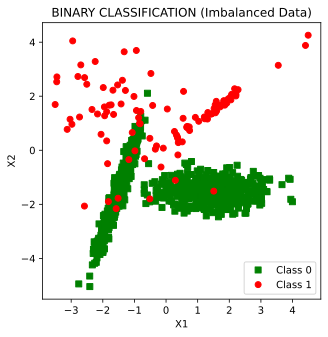

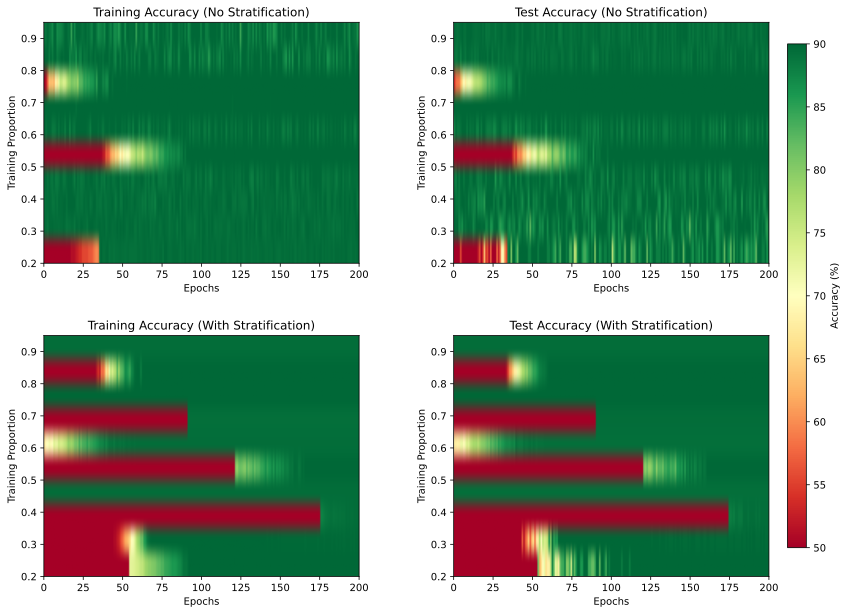

In [13]:
# ======================================
# IMPORT LIBRARIES
# ======================================
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# ======================================
# CREATE IMBALANCED DATASET
# ======================================
random_state = 42  # can choose 42 or 69

X, y = make_classification(
    n_samples=1000,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_repeated=0,
    n_classes=2,
    n_clusters_per_class=2,
    weights=[0.9, 0.1],  # 90% of class 0, 10% of class 1
    flip_y=0.01,
    class_sep=1.5,
    random_state=random_state
)

# convert to torch tensors
data = torch.tensor(X).float()
labels = torch.tensor(y).float().view(-1, 1)

# visualize dataset
fig = plt.figure(figsize=(5, 5))
plt.plot(data[np.where(labels == 0)[0], 0], data[np.where(labels == 0)[0], 1], 'gs', label='Class 0')
plt.plot(data[np.where(labels == 1)[0], 0], data[np.where(labels == 1)[0], 1], 'ro', label='Class 1')
plt.title('BINARY CLASSIFICATION (Imbalanced Data)')
plt.xlabel('X1')
plt.ylabel('X2')
plt.legend()
plt.show()

# ======================================
# MODEL CREATION FUNCTION
# ======================================
def model():
    ann = nn.Sequential(
        nn.Linear(2, 1),
        nn.ReLU(),
        nn.Linear(1, 1)
    )
    lossfunc = nn.BCEWithLogitsLoss()
    optim = torch.optim.SGD(ann.parameters(), lr=0.01)
    return ann, lossfunc, optim

# ======================================
# TRAINING FUNCTION (supports stratification)
# ======================================
epochs = 200

def train(trainProp, stratify_split=False):
    train_accuracy, test_accuracy = [], []

    for i in range(epochs):
        stratify_labels = labels if stratify_split else None

        X_train, X_test, y_train, y_test = train_test_split(
            data, labels,
            train_size=trainProp,
            random_state=None,
            shuffle=True,
            stratify=stratify_labels
        )

        pred_train = ann(X_train)
        loss = lossfunc(pred_train, y_train)

        optim.zero_grad()
        loss.backward()
        optim.step()

        pred_train_labels = (torch.sigmoid(pred_train) >= 0.5).float()
        train_accuracy.append(100 * torch.mean((pred_train_labels == y_train).float()).item())

        pred_test_labels = (torch.sigmoid(ann(X_test)) >= 0.5).float()
        test_accuracy.append(100 * torch.mean((pred_test_labels == y_test).float()).item())

    return train_accuracy, test_accuracy

# ======================================
# RUN EXPERIMENTS: WITH & WITHOUT STRATIFICATION
# ======================================
trainSetSizes = np.linspace(.2, .95, 10)
alltrain_nostrat = np.zeros((len(trainSetSizes), epochs))
alltest_nostrat  = np.zeros((len(trainSetSizes), epochs))
alltrain_strat   = np.zeros((len(trainSetSizes), epochs))
alltest_strat    = np.zeros((len(trainSetSizes), epochs))

for i, p in enumerate(trainSetSizes):
    # --- Without stratification ---
    ann, lossfunc, optim = model()
    train_acc, test_acc = train(p, stratify_split=False)
    alltrain_nostrat[i, :] = train_acc
    alltest_nostrat[i, :]  = test_acc

    # --- With stratification ---
    ann, lossfunc, optim = model()
    train_acc, test_acc = train(p, stratify_split=True)
    alltrain_strat[i, :] = train_acc
    alltest_strat[i, :]  = test_acc

# ======================================
# VISUALIZE RESULTS (Colorbar neatly on far right)
# ======================================
fig, ax = plt.subplots(2, 2, figsize=(13, 10))

# --- No Stratification ---
ax[0, 0].imshow(alltrain_nostrat, aspect='auto', vmin=50, vmax=90,
                extent=[0, epochs, trainSetSizes[0], trainSetSizes[-1]], cmap='RdYlGn')
ax[0, 0].set_title('Training Accuracy (No Stratification)')
ax[0, 0].set_xlabel('Epochs')
ax[0, 0].set_ylabel('Training Proportion')

ax[0, 1].imshow(alltest_nostrat, aspect='auto', vmin=50, vmax=90,
                extent=[0, epochs, trainSetSizes[0], trainSetSizes[-1]], cmap='RdYlGn')
ax[0, 1].set_title('Test Accuracy (No Stratification)')
ax[0, 1].set_xlabel('Epochs')
ax[0, 1].set_ylabel('Training Proportion')

# --- With Stratification ---
ax[1, 0].imshow(alltrain_strat, aspect='auto', vmin=50, vmax=90,
                extent=[0, epochs, trainSetSizes[0], trainSetSizes[-1]], cmap='RdYlGn')
ax[1, 0].set_title('Training Accuracy (With Stratification)')
ax[1, 0].set_xlabel('Epochs')
ax[1, 0].set_ylabel('Training Proportion')

im = ax[1, 1].imshow(alltest_strat, aspect='auto', vmin=50, vmax=90,
                     extent=[0, epochs, trainSetSizes[0], trainSetSizes[-1]], cmap='RdYlGn')
ax[1, 1].set_title('Test Accuracy (With Stratification)')
ax[1, 1].set_xlabel('Epochs')
ax[1, 1].set_ylabel('Training Proportion')

# --- Create a single shared colorbar to the far right ---
# Create an axes on the right side of the figure for the colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('Accuracy (%)')

plt.subplots_adjust(right=0.9, wspace=0.3, hspace=0.3)
plt.show()



#Experiment 2

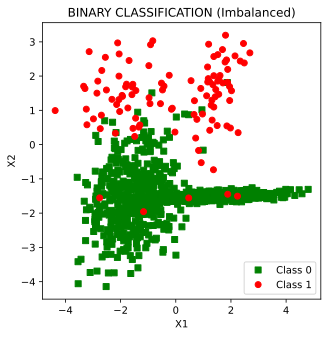

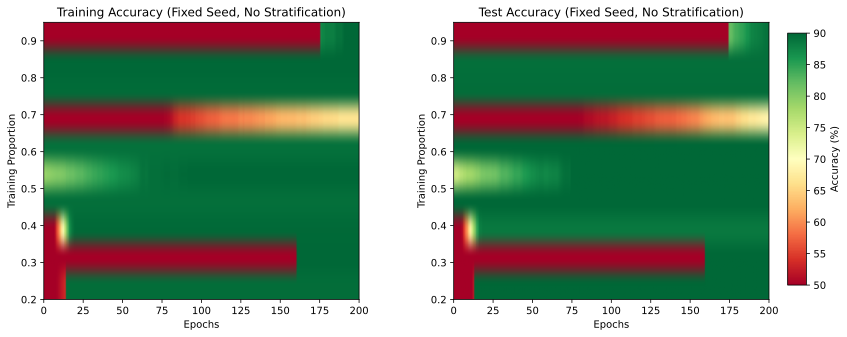

In [15]:
# ======================================
# IMPORT LIBRARIES
# ======================================
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# ======================================
# CREATE IMBALANCED DATASET
# ======================================
random_state = 74  # can choose 42 or 69

X, y = make_classification(
    n_samples=1000, n_features=2,
    n_informative=2, n_redundant=0, n_repeated=0, n_classes=2,
    n_clusters_per_class=2, weights=[0.9, 0.1],  # imbalance
    flip_y=0.01, class_sep=1.5, random_state=random_state
)

data = torch.tensor(X).float()
labels = torch.tensor(y).float().view(-1, 1)

# ======================================
# VISUALIZE DATA
# ======================================
fig = plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels==0)[0],0], data[np.where(labels==0)[0],1], 'gs', label='Class 0')
plt.plot(data[np.where(labels==1)[0],0], data[np.where(labels==1)[0],1], 'ro', label='Class 1')
plt.title('BINARY CLASSIFICATION (Imbalanced)')
plt.xlabel('X1')
plt.ylabel('X2')
plt.legend()
plt.show()

# ======================================
# MODEL FUNCTION
# ======================================
def model():
    ann = nn.Sequential(
        nn.Linear(2,1),
        nn.ReLU(),
        nn.Linear(1,1)
    )
    lossfunc = nn.BCEWithLogitsLoss()
    optim = torch.optim.SGD(ann.parameters(), lr=0.01)
    return ann, lossfunc, optim

# ======================================
# TRAIN FUNCTION (FIXED RANDOM SEED)
# ======================================
epochs = 200

def train(trainProp, seed_value=123):
    train_accuracy, test_accuracy = [], []

    # set the random seed once for consistent splits
    np.random.seed(seed_value)

    for i in range(epochs):
        # same random seed each epoch → same split
        X_train, X_test, y_train, y_test = train_test_split(
            data, labels,
            train_size=trainProp,
            random_state=seed_value,
            shuffle=True,
            stratify=None
        )

        pred_train = ann(X_train)
        loss = lossfunc(pred_train, y_train)

        optim.zero_grad()
        loss.backward()
        optim.step()

        pred_train_labels = (torch.sigmoid(pred_train) >= 0.5).float()
        train_accuracy.append(100 * torch.mean((pred_train_labels == y_train).float()).item())

        pred_test_labels = (torch.sigmoid(ann(X_test)) >= 0.5).float()
        test_accuracy.append(100 * torch.mean((pred_test_labels == y_test).float()).item())

    return train_accuracy, test_accuracy

# ======================================
# RUN EXPERIMENT (NO STRATIFICATION + FIXED SEED)
# ======================================
trainSetSizes = np.linspace(.2, .95, 10)
alltrain_fixed = np.zeros((len(trainSetSizes), epochs))
alltest_fixed  = np.zeros((len(trainSetSizes), epochs))

for i, p in enumerate(trainSetSizes):
    ann, lossfunc, optim = model()
    train_acc, test_acc = train(p, seed_value=191)
    alltrain_fixed[i, :] = train_acc
    alltest_fixed[i, :]  = test_acc

# ======================================
# VISUALIZE RESULTS (fixed colorbar placement)
# ======================================
fig, ax = plt.subplots(1, 2, figsize=(13, 5))

# --- Training accuracy ---
ax[0].imshow(alltrain_fixed, aspect='auto', vmin=50, vmax=90,
             extent=[0, epochs, trainSetSizes[0], trainSetSizes[-1]], cmap='RdYlGn')
ax[0].set_title('Training Accuracy (Fixed Seed, No Stratification)')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Training Proportion')

# --- Test accuracy ---
im = ax[1].imshow(alltest_fixed, aspect='auto', vmin=50, vmax=90,
                  extent=[0, epochs, trainSetSizes[0], trainSetSizes[-1]], cmap='RdYlGn')
ax[1].set_title('Test Accuracy (Fixed Seed, No Stratification)')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training Proportion')

# --- Create a dedicated colorbar axis ---
# [left, bottom, width, height] are relative to figure dimensions (0–1)
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('Accuracy (%)')

# Adjust subplot spacing so the plots don't touch the colorbar
plt.subplots_adjust(right=0.9, wspace=0.3)
plt.show()



#Experiment 3

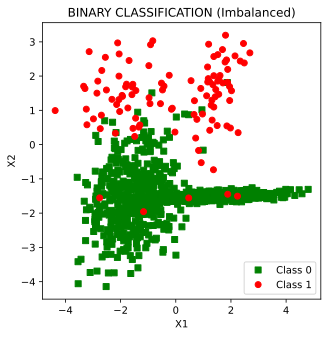

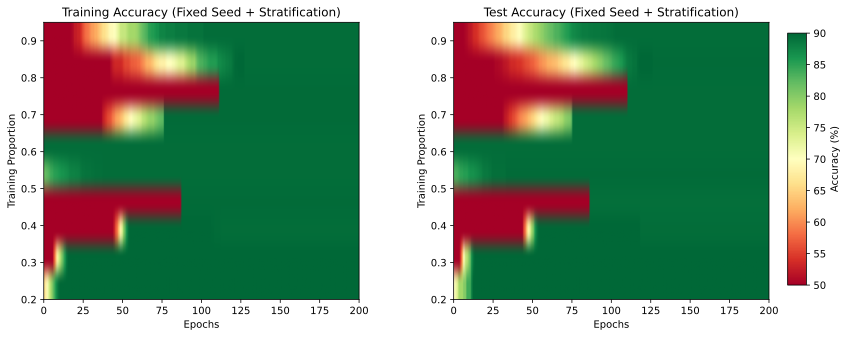

In [16]:
# ======================================
# IMPORT LIBRARIES
# ======================================
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# ======================================
# CREATE IMBALANCED DATASET
# ======================================
random_state = 74  # can choose 42 or 69

X, y = make_classification(
    n_samples=1000, n_features=2,
    n_informative=2, n_redundant=0, n_repeated=0, n_classes=2,
    n_clusters_per_class=2, weights=[0.9, 0.1],  # imbalance
    flip_y=0.01, class_sep=1.5, random_state=random_state
)

data = torch.tensor(X).float()
labels = torch.tensor(y).float().view(-1, 1)

# ======================================
# VISUALIZE DATA
# ======================================
fig = plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels==0)[0],0], data[np.where(labels==0)[0],1], 'gs', label='Class 0')
plt.plot(data[np.where(labels==1)[0],0], data[np.where(labels==1)[0],1], 'ro', label='Class 1')
plt.title('BINARY CLASSIFICATION (Imbalanced)')
plt.xlabel('X1')
plt.ylabel('X2')
plt.legend()
plt.show()

# ======================================
# MODEL FUNCTION
# ======================================
def model():
    ann = nn.Sequential(
        nn.Linear(2,1),
        nn.ReLU(),
        nn.Linear(1,1)
    )
    lossfunc = nn.BCEWithLogitsLoss()
    optim = torch.optim.SGD(ann.parameters(), lr=0.01)
    return ann, lossfunc, optim

# ======================================
# TRAIN FUNCTION (FIXED SEED + STRATIFICATION)
# ======================================
epochs = 200

def train(trainProp, seed_value=191):
    train_accuracy, test_accuracy = [], []

    np.random.seed(seed_value)

    for i in range(epochs):
        # same random seed → same stratified split every epoch
        X_train, X_test, y_train, y_test = train_test_split(
            data, labels,
            train_size=trainProp,
            random_state=seed_value,
            shuffle=True,
            stratify=labels  # stratify by labels here
        )

        pred_train = ann(X_train)
        loss = lossfunc(pred_train, y_train)

        optim.zero_grad()
        loss.backward()
        optim.step()

        pred_train_labels = (torch.sigmoid(pred_train) >= 0.5).float()
        train_accuracy.append(100 * torch.mean((pred_train_labels == y_train).float()).item())

        pred_test_labels = (torch.sigmoid(ann(X_test)) >= 0.5).float()
        test_accuracy.append(100 * torch.mean((pred_test_labels == y_test).float()).item())

    return train_accuracy, test_accuracy

# ======================================
# RUN EXPERIMENT (FIXED SEED + STRATIFICATION)
# ======================================
trainSetSizes = np.linspace(.2, .95, 10)
alltrain_strat_fixed = np.zeros((len(trainSetSizes), epochs))
alltest_strat_fixed  = np.zeros((len(trainSetSizes), epochs))

for i, p in enumerate(trainSetSizes):
    ann, lossfunc, optim = model()
    train_acc, test_acc = train(p, seed_value=191)
    alltrain_strat_fixed[i, :] = train_acc
    alltest_strat_fixed[i, :]  = test_acc

# ======================================
# VISUALIZE RESULTS (clean colorbar placement)
# ======================================
fig, ax = plt.subplots(1, 2, figsize=(13, 5))

# Training accuracy
ax[0].imshow(alltrain_strat_fixed, aspect='auto', vmin=50, vmax=90,
             extent=[0, epochs, trainSetSizes[0], trainSetSizes[-1]], cmap='RdYlGn')
ax[0].set_title('Training Accuracy (Fixed Seed + Stratification)')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Training Proportion')

# Test accuracy
im = ax[1].imshow(alltest_strat_fixed, aspect='auto', vmin=50, vmax=90,
                  extent=[0, epochs, trainSetSizes[0], trainSetSizes[-1]], cmap='RdYlGn')
ax[1].set_title('Test Accuracy (Fixed Seed + Stratification)')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training Proportion')

# Dedicated colorbar axis
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('Accuracy (%)')

plt.subplots_adjust(right=0.9, wspace=0.3)
plt.show()


#Experiment 4

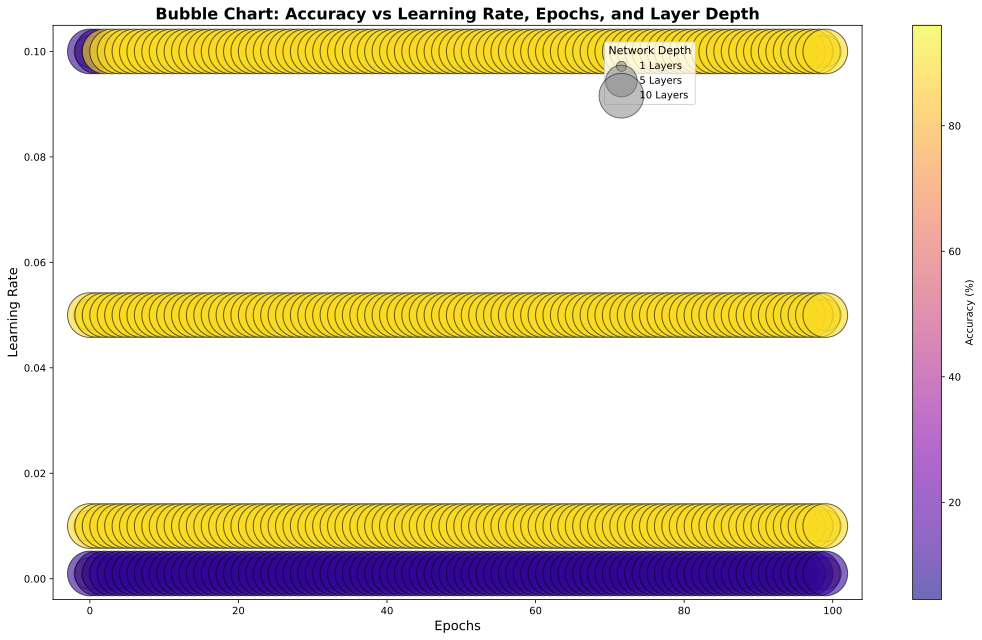

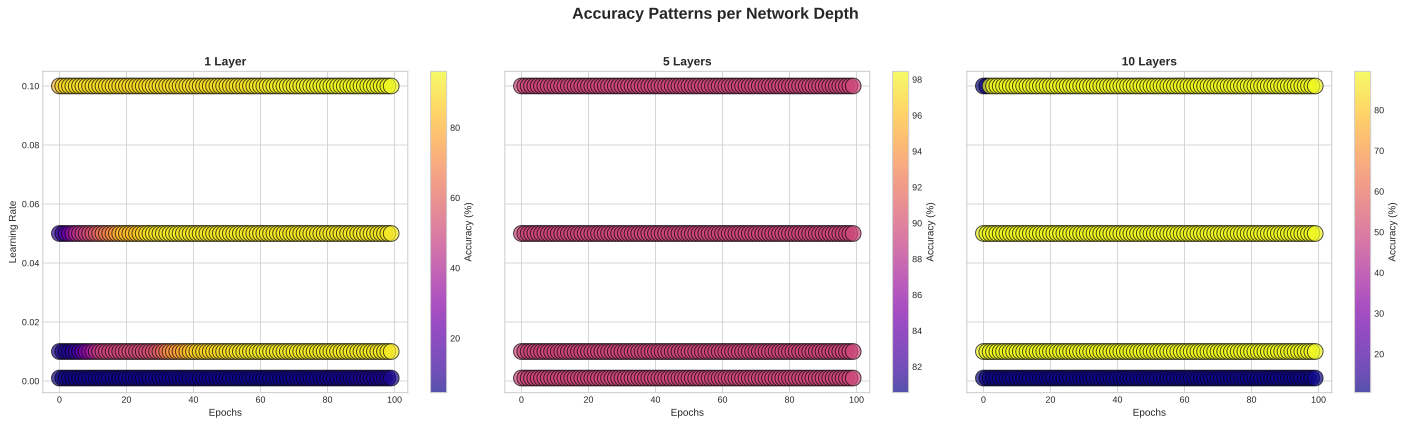

In [19]:
# ---------------------------------------------------------
# IMPORT LIBRARIES
# ---------------------------------------------------------
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# ---------------------------------------------------------
# CREATE IMBALANCED DATASET
# ---------------------------------------------------------
random_state = 42
X, y = make_classification(
    n_samples=1000, n_features=2, n_informative=2, n_redundant=0,
    n_classes=2, weights=[0.9, 0.1], flip_y=0.01, class_sep=1.5, random_state=random_state
)

data = torch.tensor(X).float()
labels = torch.tensor(y).float().view(-1, 1)

# ---------------------------------------------------------
# MODEL FUNCTION
# ---------------------------------------------------------
def create_model(num_layers=1, lr=0.01):
    layers = []
    input_dim = 2
    hidden_dim = 4

    for _ in range(num_layers):
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(nn.ReLU())
        input_dim = hidden_dim

    layers.append(nn.Linear(hidden_dim, 1))  # output layer
    ann = nn.Sequential(*layers)
    lossfunc = nn.BCEWithLogitsLoss()
    optim = torch.optim.SGD(ann.parameters(), lr=lr)
    return ann, lossfunc, optim

# ---------------------------------------------------------
# TRAIN FUNCTION
# ---------------------------------------------------------
def train_model(ann, lossfunc, optim, epochs=100, train_size=0.8):
    X_train, X_test, y_train, y_test = train_test_split(
        data, labels, train_size=train_size, stratify=labels, random_state=42
    )

    accuracies = []
    for ep in range(epochs):
        pred = ann(X_train)
        loss = lossfunc(pred, y_train)
        optim.zero_grad()
        loss.backward()
        optim.step()

        with torch.no_grad():
            preds_test = torch.sigmoid(ann(X_test))
            pred_labels = (preds_test >= 0.5).float()
            acc = 100 * torch.mean((pred_labels == y_test).float()).item()
        accuracies.append(acc)
    return accuracies

# ---------------------------------------------------------
# EXPERIMENT SETUP
# ---------------------------------------------------------
epochs = 100
num_layers_list = [1, 5, 10]
learning_rates = [0.001, 0.01, 0.05, 0.1]

results = []

for num_layers in num_layers_list:
    for lr in learning_rates:
        ann, lossfunc, optim = create_model(num_layers=num_layers, lr=lr)
        acc = train_model(ann, lossfunc, optim, epochs=epochs)
        for ep, a in enumerate(acc):
            results.append([ep, lr, num_layers, a])

results = np.array(results)

# ---------------------------------------------------------
# Bubble Chart
# ---------------------------------------------------------
plt.figure(figsize=(15,9))

# map bubble size to number of layers
size_map = {1: 100, 5: 1000, 10: 2000}
bubble_sizes = [size_map[int(l)] for l in results[:,2]]

scatter = plt.scatter(
    results[:,0].astype(float),        # x-axis (epochs)
    results[:,1].astype(float),        # y-axis (learning rate)
    s=bubble_sizes,                    # bubble size = layers
    c=results[:,3].astype(float),      # color = accuracy
    cmap='plasma', alpha=0.6, edgecolors='black'
)

plt.colorbar(scatter, label='Accuracy (%)')
plt.xlabel('Epochs', fontsize=13)
plt.ylabel('Learning Rate', fontsize=13)
plt.title('Bubble Chart: Accuracy vs Learning Rate, Epochs, and Layer Depth', fontsize=16, weight='bold')

# Legend for bubble sizes (inside empty area)
handles = [plt.scatter([], [], s=size_map[l], color='gray', alpha=0.5, edgecolors='black', label=f'{l} Layers')
            for l in num_layers_list]

plt.legend(
    handles=handles,
    title='Network Depth',
    loc='upper right',
    bbox_to_anchor=(0.80, 0.98),
    frameon=True,
    fontsize=10,
    title_fontsize=11
)

plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# Individual Graphs for Each Layer Configuration
# ---------------------------------------------------------
plt.style.use('seaborn-v0_8-whitegrid')

unique_layers = sorted(list(set(results[:,2].astype(int))))
fig, axes = plt.subplots(1, len(unique_layers), figsize=(20, 6), sharey=True)

for i, layer in enumerate(unique_layers):
    layer_mask = results[:,2].astype(int) == layer
    subset = results[layer_mask]

    sc = axes[i].scatter(
        subset[:,0].astype(float),     # x-axis: epochs
        subset[:,1].astype(float),     # y-axis: learning rate
        s=250,                         # constant bubble size
        c=subset[:,3].astype(float),   # color = accuracy
        cmap='plasma', edgecolors='black', alpha=0.7
    )

    cbar = fig.colorbar(sc, ax=axes[i])
    cbar.set_label('Accuracy (%)', fontsize=10)
    cbar.ax.tick_params(labelsize=9)

    axes[i].set_title(f'{layer} Layer{"s" if layer > 1 else ""}', fontsize=12, weight='bold')
    axes[i].set_xlabel('Epochs', fontsize=10)
    if i == 0:
        axes[i].set_ylabel('Learning Rate', fontsize=10)
    axes[i].tick_params(axis='both', labelsize=9)

plt.suptitle('Accuracy Patterns per Network Depth', fontsize=16, weight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


#Experiment 5

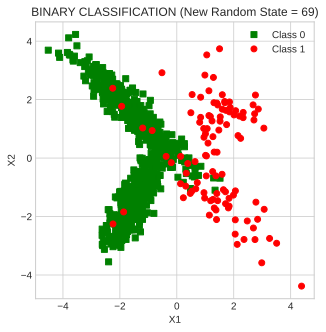

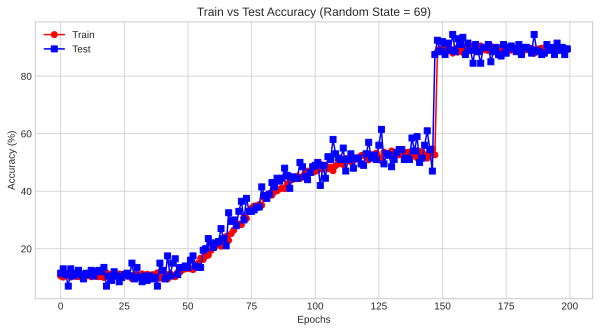

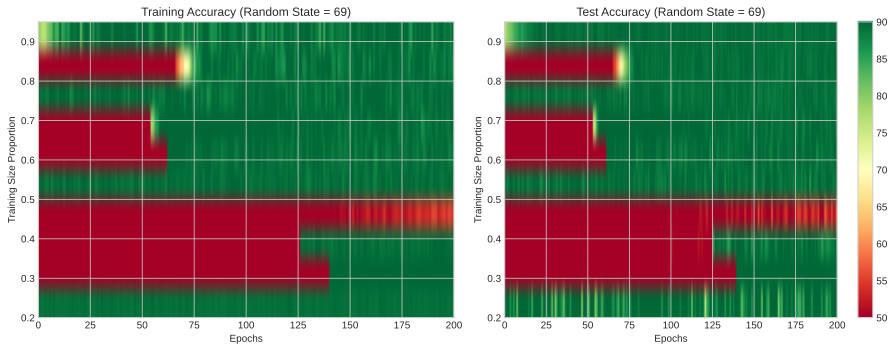

In [20]:
# ======================================
# IMPORT LIBRARIES
# ======================================
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# ======================================
# CREATE A SLIGHTLY DIFFERENT IMBALANCED DATASET
# ======================================
random_state = 69  # <-- changed from 42 to 69

X, y = make_classification(
    n_samples=1000, n_features=2,
    n_informative=2, n_redundant=0, n_repeated=0, n_classes=2,
    n_clusters_per_class=2, weights=[0.9, 0.1],  # imbalance
    flip_y=0.01, class_sep=1.5, random_state=random_state
)

# convert to PyTorch tensors
data = torch.tensor(X).float()
labels = torch.tensor(y).float().view(-1, 1)

# ======================================
# VISUALIZE THE DATA
# ======================================
fig = plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels==0)[0],0], data[np.where(labels==0)[0],1], 'gs', label='Class 0')
plt.plot(data[np.where(labels==1)[0],0], data[np.where(labels==1)[0],1], 'ro', label='Class 1')
plt.title('BINARY CLASSIFICATION (New Random State = 69)')
plt.xlabel('X1')
plt.ylabel('X2')
plt.legend()
plt.show()

# ======================================
# MODEL FUNCTION
# ======================================
def model():
    ann = nn.Sequential(
        nn.Linear(2,1),
        nn.ReLU(),
        nn.Linear(1,1)
    )
    lossfunc = nn.BCEWithLogitsLoss()
    optim = torch.optim.SGD(ann.parameters(), lr=0.01)
    return ann, lossfunc, optim

# ======================================
# TRAIN FUNCTION
# ======================================
epochs = 200

def train(trainProp):
    train_accuracy = []
    test_accuracy = []

    for i in range(epochs):
        # random split per epoch (not stratified)
        X_train, X_test, y_train, y_test = train_test_split(
            data, labels, train_size=trainProp, random_state=None, shuffle=True
        )

        pred_train = ann(X_train)
        loss = lossfunc(pred_train, y_train)
        optim.zero_grad()
        loss.backward()
        optim.step()

        # compute accuracy for training set
        pred_train_labels = (torch.sigmoid(pred_train) >= 0.5).float()
        train_acc = 100 * torch.mean((pred_train_labels == y_train).float()).item()
        train_accuracy.append(train_acc)

        # compute accuracy for test set
        pred_test = ann(X_test)
        pred_test_labels = (torch.sigmoid(pred_test) >= 0.5).float()
        test_acc = 100 * torch.mean((pred_test_labels == y_test).float()).item()
        test_accuracy.append(test_acc)

    return train_accuracy, test_accuracy

# ======================================
# TEST THE MODEL ONCE
# ======================================
ann, lossfunc, optim = model()
train_accuracy, test_accuracy = train(0.8)

fig = plt.figure(figsize=(10,5))
plt.plot(train_accuracy, 'ro-', label='Train')
plt.plot(test_accuracy, 'bs-', label='Test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Train vs Test Accuracy (Random State = 69)')
plt.legend()
plt.show()

# ======================================
# EXPERIMENT ACROSS TRAINING SET SIZES
# ======================================
trainSetSizes = np.linspace(.2, .95, 10)
alltrain_accuracy = np.zeros((len(trainSetSizes), epochs))
alltest_accuracy  = np.zeros((len(trainSetSizes), epochs))

for i, p in enumerate(trainSetSizes):
    ann, lossfunc, optim = model()
    train_acc, test_acc = train(p)
    alltrain_accuracy[i, :] = train_acc
    alltest_accuracy[i, :]  = test_acc

# ======================================
# VISUALIZE RESULTS
# ======================================
fig, ax = plt.subplots(1, 2, figsize=(13, 5))

# Training accuracy
ax[0].imshow(alltrain_accuracy, aspect='auto', vmin=50, vmax=90,
             extent=[0, epochs, trainSetSizes[0], trainSetSizes[-1]], cmap='RdYlGn')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Training Size Proportion')
ax[0].set_title('Training Accuracy (Random State = 69)')

# Test accuracy
p = ax[1].imshow(alltest_accuracy, aspect='auto', vmin=50, vmax=90,
                 extent=[0, epochs, trainSetSizes[0], trainSetSizes[-1]], cmap='RdYlGn')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training Size Proportion')
ax[1].set_title('Test Accuracy (Random State = 69)')

fig.colorbar(p, ax=ax[1])
plt.tight_layout()
plt.show()
